In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import math

from pykern import pkjson
from pykern.pkcollections import PKDict
import py.path

import Shadow
from Shadow.ShadowPreprocessorsXraylib import prerefl, pre_mlayer, bragg
from srxraylib.sources import srfunc
from sirepo.template import transfer_mat_bl

In [2]:
sigmax = 0.0045000000000000005
sigdix = 2.913e-05
sigmaz = 0.0045000000000000005
sigdiz = 2.913e-05

In [3]:
beam_stats = []
epsilon = 1e-06
ph_energy = 135.824
beam = transfer_mat_bl.create_mat_rays(epsilon, ph_energy)

In [4]:
sigma_mat = numpy.matrix([
    [sigmax ** 2, 0, 0, 0],
    [0, sigdix ** 2, 0, 0],
    [0, 0, sigmaz ** 2, 0],
    [0, 0, 0, sigdiz ** 2],
])
alpha = 0

def calculate_stats(pos, oe):
    global alpha
    Tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = transfer_mat_bl.tmat_calc(beam.duplicate(), epsilon)
    res = Tmat * sigma_mat * numpy.transpose(Tmat)
    pos += (oe.T_SOURCE if oe else 0)
    if oe:
        # oe.ALPHA is in radians after traceOE()
        alpha = int(alpha + 180 / math.pi * oe.ALPHA) % 360
    beam_stats.append(PKDict(
        isRotated=True if alpha == 90 or alpha == 270 else False,
        s=pos * 1e-2,
        x=x_prop_cen,
        xp=xp_prop_cen,
        z=z_prop_cen,
        zp=zp_prop_cen,
        matrix=Tmat.tolist(),
        sigmax=math.sqrt(res[0, 0]) * 1e-2,
        sigdix=math.sqrt(res[1, 1]),
        sigmaz=math.sqrt(res[2, 2]) * 1e-2,
        sigdiz=math.sqrt(res[3, 3]),
    ))
    return pos

pos = calculate_stats(0, None)

In [5]:
# drift, 28.5 m
for j in range(1, 100):
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty(ALPHA=0)
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 28.5
    beam.traceOE(oe, j)
    pos = calculate_stats(pos, oe)

In [6]:
# mirror, M1
oe = Shadow.OE()
oe.DUMMY = 1.0
oe.FMIRR = 2
oe.ALPHA = 0
oe.FHIT_C = 0
oe.F_EXT = 0
oe.F_DEFAULT = 0
oe.SSOUR = 2900.0
oe.SIMAG = 1000.0
oe.THETA = 2.0002
oe.F_CONVEX = 0
oe.FCYL = 1
oe.CIL_ANG = 90.0
oe.T_INCIDENCE = 2.0
oe.T_REFLECTION = 2.0
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 28.5
beam.traceOE(oe, 100)
pos = calculate_stats(pos, oe)

In [7]:
# drift, 1 m
for j in range(101, 200):
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty(ALPHA=0)
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 1.0
    beam.traceOE(oe, j)
    pos = calculate_stats(pos, oe)

In [8]:
# mirror, M2
oe = Shadow.OE()
oe.DUMMY = 1.0
oe.FMIRR = 2
oe.ALPHA = 0
oe.FHIT_C = 1
oe.F_EXT = 0
oe.F_DEFAULT = 0
oe.SSOUR = 3000.0
oe.SIMAG = 900.0
oe.THETA = 2.0002
oe.F_CONVEX = 0
oe.FCYL = 1
oe.CIL_ANG = 0.0
oe.FSHAPE = 2
oe.RWIDX2 = 15.0
oe.RLEN2 = 25.0
oe.F_MOVE = 1
oe.OFFX = 1.0
oe.T_INCIDENCE = 2.0
oe.T_REFLECTION = 2.0
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 1.0
beam.traceOE(oe, 200)
pos = calculate_stats(pos, oe)

In [9]:
# drift, 9.05 m
for j in range(201, 300):
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty(ALPHA=0)
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 9.050000000000182
    beam.traceOE(oe, j)
    pos = calculate_stats(pos, oe)

In [10]:
# watch-point, 
oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty()
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 9.049999999981537
beam.traceOE(oe, 300)
pos = calculate_stats(pos, oe)

In [11]:
# drift, 0.95 m
for j in range(301, 401):
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty(ALPHA=0)
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 0.9499999999998181
    beam.traceOE(oe, j)
    pos = calculate_stats(pos, oe)

In [12]:
# watch-point, 
oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty()
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 1.864464138634503e-11
beam.traceOE(oe, 401)
pos = calculate_stats(pos, oe)

In [13]:
pkjson.dump_pretty(beam_stats, filename='beam_stats.json');

In [14]:
# Shadow.ShadowTools.plotxy(beam, 1, 3, nbins=100, nolost=1)

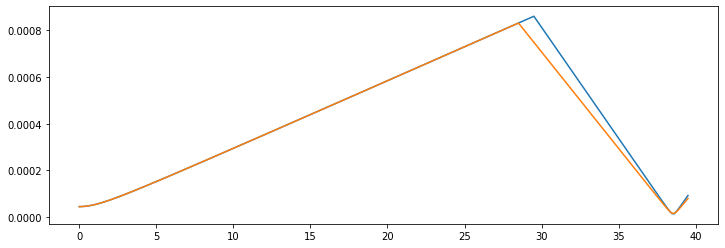

In [15]:
beam_stats = pkjson.load_any(py.path.local('beam_stats.json'))

sigmax = [record.sigmax for record in beam_stats]
sigmaz = [record.sigmaz for record in beam_stats]
sigdix = [record.sigdix for record in beam_stats]
sigdiz = [record.sigdiz for record in beam_stats]

x = [record.s for record in beam_stats]
y1 = [record.sigmaz if record.isRotated else record.sigmax for record in beam_stats]
y2 = [record.sigmax if record.isRotated else record.sigmaz for record in beam_stats]

plt.figure(figsize=(12,4))
# plt.title("population inversion density")
plt.plot(x, sigmaz, x, sigmax)
plt.show()